# Домашнее задание №5

##### Автор: [Татьяна Гайнцева](https://www.linkedin.com/in/tgaintseva/), @atmyre

В этом домашнем задании вам предстоит обучить нейросеть на задачу предсказания героев сериала "Симпсоны".

Вам будет дан тренировочный и тестовый наборы данных. Вам нужно будет обучить нейросеть на тренировочных данных и получить предсказания на тестовых данных. Эти предсказания нужно будет отправить на Я.Контест. Ваш балл за задание — значение метрики accuracy между предсказаниями вашей модели и правильными ответами на тестовый набор картинок.

Ниже дан код скачивания и загрузки данных, с которыми вы будете работать.

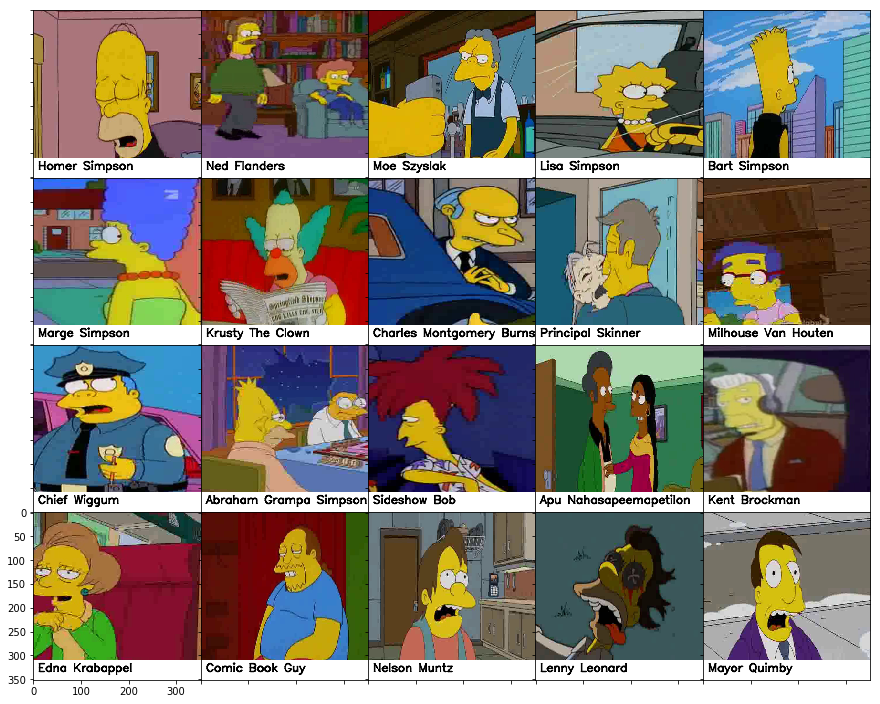

## Загрузка данных

Две ячейки ниже скачивают архив с данными и распаковывают этот архив. Не нужно менять эту ячейку.

In [1]:
#! pip install wldhx.yadisk-direct
#! curl -L $(yadisk-direct https://disk.yandex.com/d/Ggl9017wNIN0vg) -o simpsons.zip

***Замечание!*** Яндекс. Диск накладывает некоторые ограничения на число одновременных скачиваний в день по ссылкам. Поэтому, код в ячейке выше может выдавать ошибку. В этом случае необходимо будет раскомментировать и запустить код из ячейки ниже (в ней данные скачиваются по альтернативной ссылке):

In [2]:
#! pip install wldhx.yadisk-direct
#! curl -L $(yadisk-direct https://disk.yandex.ru/d/MweozIqon2ybsQ) -o simpsons.zip

Далее разархивируем скачанный архив. Не нужно менять эту ячейку:

In [3]:
#!unzip -qq simpsons.zip

Импортируем нужные библиотеки:

In [4]:
import numpy as np
import matplotlib.pyplot as plt

from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim

import torchvision
from torchvision import datasets, models, transforms

In [5]:
import os
import random
import math
import sys
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.nn import functional as F
import torchvision
import torchvision.transforms as transforms
import seaborn as sns

from torchvision.transforms import v2
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from torchvision import models
from torchmetrics import Accuracy
from tqdm import tqdm
from PIL import Image
from torchvision.transforms import AutoAugment, AutoAugmentPolicy
from torchvision.transforms import RandomErasing
import warnings

# Suppress specific FutureWarning
warnings.filterwarnings("ignore", category=FutureWarning, message="use_inf_as_na option is deprecated and will be removed")



Зададим преобразования, которые будут совершаться c изображениями перед подачей в нейросеть. Вы можете изменять эти преобразования по своему желанию.

Обратите внимание, что если вы собираетесь использовать предобученную нейросеть (vgg, resnet, ...), то преобразования должны быть теми же, что использовались при предобучении этой нейросети. Какие преобразования используются для той или иной сети и как использовать их в коде, можно найти в [документации pytorch](https://pytorch.org/vision/stable/models.html).

Если же вы будете обучать свою собственную нейросеть с нуля, вы можете выбирать преобразования по своему усмотрению.

In [6]:
resnet_transforms = transforms.Compose([
        transforms.Resize(256), # размер каждой картинки будет приведен к 256*256
        transforms.CenterCrop(224), # у картинки будет вырезан центральный кусок размера 224*224
        transforms.ToTensor(), # картинка из питоновского массива переводится в формат torch.Tensor
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # значения пикселей картинки нормализуются
    ])

# преобразования для конкретной предобученной сети проще получить вот так
# resnet_transforms = models.ResNet18_Weights.IMAGENET1K_V1.transforms()

train_transform = transforms.Compose(
    [
        transforms.Resize((224, 224), interpolation=transforms.InterpolationMode.BICUBIC),
        transforms.AutoAugment(policy=AutoAugmentPolicy.IMAGENET),
        #transforms.ColorJitter(hue=0.05, saturation=0.05),
        #transforms.RandomHorizontalFlip(),
        #transforms.RandomRotation(10, fill=(0, 0, 0)),
        #transforms.GaussianBlur(kernel_size=(5, 9), sigma=(0.1, 5)),
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261)),
    ]
)

val_transform = torchvision.transforms.Compose(
    [
        transforms.Resize((224, 224), interpolation=transforms.InterpolationMode.BICUBIC),
        #transforms.CenterCrop((224, 224)),
        torchvision.transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261)),
    ]
)


Создадим датасеты из данных. Обратите внимание, что для тестовых данных вам не известны ответы: внутри папки `./simpsons_data/test` нет подпапок с названиями классов, там всего одна папка со всеми изображениями. Ваша задача — обучить нейросеть, используя тренировочные данные, для которых вам известны ответы, получить с помощью обученной нейросети предсказания для тестовых данных и сдать их в качестве ответа.

In [7]:
train_data = datasets.ImageFolder('./simpsons/simpsons_data/train', transform=train_transform)
test_data = datasets.ImageFolder('./simpsons/simpsons_data/test', transform=val_transform)

Получим соответствие номеров классов и их названий:

In [8]:
class_to_idx = train_data.class_to_idx
class_to_idx

{'abraham_grampa_simpson': 0,
 'agnes_skinner': 1,
 'apu_nahasapeemapetilon': 2,
 'barney_gumble': 3,
 'bart_simpson': 4,
 'carl_carlson': 5,
 'charles_montgomery_burns': 6,
 'chief_wiggum': 7,
 'cletus_spuckler': 8,
 'comic_book_guy': 9,
 'disco_stu': 10,
 'edna_krabappel': 11,
 'fat_tony': 12,
 'gil': 13,
 'groundskeeper_willie': 14,
 'homer_simpson': 15,
 'kent_brockman': 16,
 'krusty_the_clown': 17,
 'lenny_leonard': 18,
 'lionel_hutz': 19,
 'lisa_simpson': 20,
 'maggie_simpson': 21,
 'marge_simpson': 22,
 'martin_prince': 23,
 'mayor_quimby': 24,
 'milhouse_van_houten': 25,
 'miss_hoover': 26,
 'moe_szyslak': 27,
 'ned_flanders': 28,
 'nelson_muntz': 29,
 'otto_mann': 30,
 'patty_bouvier': 31,
 'principal_skinner': 32,
 'professor_john_frink': 33,
 'rainier_wolfcastle': 34,
 'ralph_wiggum': 35,
 'selma_bouvier': 36,
 'sideshow_bob': 37,
 'sideshow_mel': 38,
 'snake_jailbird': 39,
 'troy_mcclure': 40,
 'waylon_smithers': 41}

Разделим тренировочную выборку на две части: тренировочную и валидационную. На тренировочной части, как обычно, будем обучать нейросеть, а на валидационной будем сеть тестировать.

In [9]:
# в тренировочную выборку отнесем 80% всех картинок
train_size = int(len(train_data) * 0.8)
# в валидационную — остальные 20%
val_size = len(train_data) - train_size

train_data, val_data = torch.utils.data.random_split(train_data, [train_size, val_size])

Создадим три даталоадера для трех частей данных:

In [10]:
train_dataloader = torch.utils.data.DataLoader(train_data, batch_size=32, shuffle=True, num_workers=4)
val_dataloader = torch.utils.data.DataLoader(val_data, batch_size=32, shuffle=False, num_workers=4)
test_dataloader = torch.utils.data.DataLoader(test_data, batch_size=32, shuffle=False)

И посмотрим на несколько картинок из обучающей выборки, чтобы понимать, с чем мы имеем дело.

In [12]:
for batch in test_dataloader:
    # батч картинок и батч ответов к картинкам
    images, labels = batch
    break

In [13]:
def show_images(images, labels):
    f, axes= plt.subplots(1, 10, figsize=(30,5))

    for i, axis in enumerate(axes):
        # переводим картинку из тензора в numpy
        img = images[i].numpy()
        # переводим картинку в размерность (длина, ширина, цветовые каналы)
        img = np.transpose(img, (1, 2, 0))

        axes[i].imshow(img)
        axes[i].set_title(labels[i].numpy())

    plt.show()

Отрисуем картинки. Картинки будут отрисованы уже после преобразований (transforms), поэтому они могут быть не очень естественных цветов, если среди преобразований была нормализация. Не пугайтесь =)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.9894737..2.011479].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.9843621..2.0455637].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.9894737..1.773327].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.9894737..1.8201863].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.9894737..2.1056645].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.9894737..1.9320949].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.9843621.

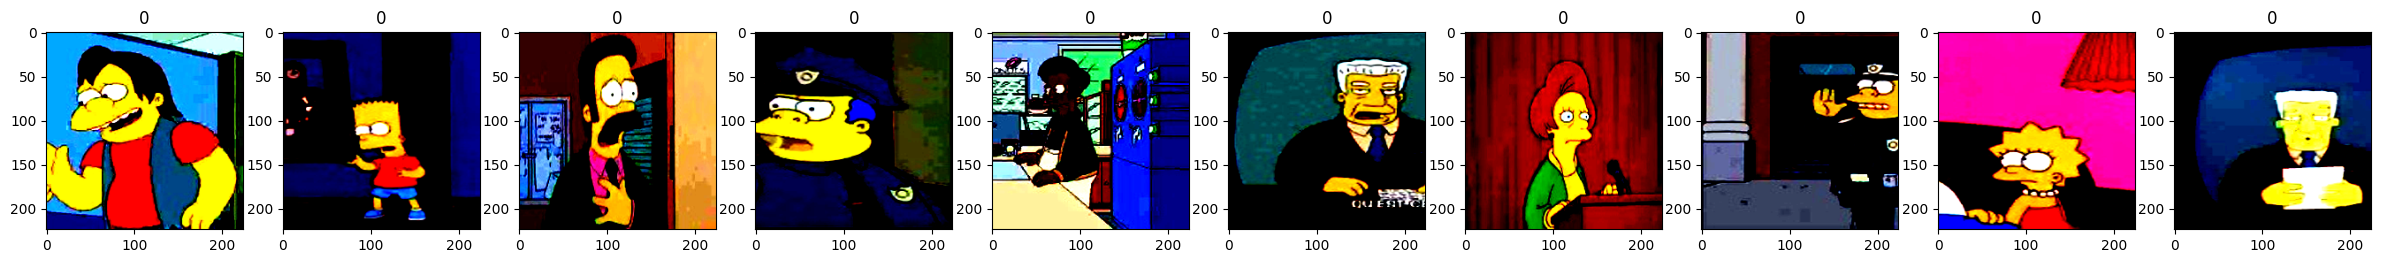

In [14]:
show_images(images, labels)

## Построение и обучение модели

Ваша задача — обучить нейросеть на тренировочных и валидационных данных, и получить предсказания на тестовых данных. Эти предсказания нужно будет отправить в качестве решения на Я.Контест. Ваш итоговый балл будет определяться как значение метрики accuracy, посчитанное между правильными ответами на картинки тестовой выборки, и ответами вашей модели, которые вы отправили в систему.

Для построения и обучения нейросети можно и нужно пользоваться материалами с прошлых семинаров и домашних заданий.

Идеи, как получить больший скор:
- попробуйте обучить свою нейросеть с нуля, как мы это делали на четвертом занятии и в четвертом домашнем задании. Попробуйте варьировать архитектуру сети и различные гиперпараметры (количество слоев, фильтров в слоях и т.п.), чтобы получить лучший скор на валидации;
- попробуйте взять предобученную нейросеть (resnet-18, к примеру), и дообучить ее на наших данных, как мы это делали на пятом занятии. Обратите внимание на преобразования (transforms): они должны соответствовать той архитектуре, которую вы дообучаете. Попробуйте замораживать разное количество слоев, посмотрите, как это влияет на результат.
- попробуйте применить аугментацию данных для тренировочной выборки. Про аугментацию данных [можно почитать на Хабре](https://habr.com/ru/company/smartengines/blog/264677/). Примеры аугментации в pytorch [можно найти в документации](https://pytorch.org/vision/stable/transforms.html).
Обратите внимание, что аугментация должна применяться только к обучающей (train) выборке. К валидационной и тестовой выборкам она применяться не должна. Поэтому вам нужно будет создать два разных пайплайна transforms: один для тренировочной части, один для валидационной и тестовой частей.

В процессе обучения сети обращайте внимание на скор на валидации. Значение метрики на валидации — это ориентир, который позволяет понять, как примерно будет вести себя ваша сеть на тестовой выборке. Но обратите внимание, что результат на тестовой и валидационной выборке может отличаться.

У вас 100 попыток сдачи решения в Я.Контест: это очень много. Но мы просим вас подойти к заданию осознанно. Пожалуйста, не перебирайте ответы бездумно и не посылайте в качестве ответа все подряд. Старайтесь получить хорошую нейросеть перед тем как отправлять ее ответы на Я.Контест.

----------------

Проверяем, доступен ли GPU (если не доступен, включите GPU в настройках ноутбука):

In [15]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [16]:
# ВАШ КОД: постройте и обучите нейросеть
class SimpleNet(nn.Module):
    def __init__(self, model):
        super(SimpleNet, self).__init__()
        self.total = 0
        self.correct = 0
        self.model = model

    def _forward(self, x):
        x = self.model(x)
        return x

    def forward(self, images, target=None):
        logits = self._forward(images)
        if target is None:
            return logits
        else:
            loss = F.cross_entropy(logits, target)
            preds = logits.argmax(dim=1)
            self.total += target.size(0)
            self.correct += (preds == target).sum().item()
            return loss

    def get_accuracy(self, reset=False):
        if self.total == 0:
            return 0.0
        accuracy = self.correct / self.total
        if reset:
            self.correct = 0
            self.total = 0
        return accuracy

class YourModule(nn.Module):
    def __init__(self, model, backbone_lr=1e-4, classifier_lr=1e-3):
        super(YourModule, self).__init__()
        self.model = model
        self.loss_fn = nn.CrossEntropyLoss()
        self.accuracy = Accuracy(task='multiclass', num_classes=42)
        self.backbone_lr = backbone_lr
        self.classifier_lr = classifier_lr

    def forward(self, x):
        return self.model(x)

    def train_one_epoch(self, train_loader, optimizer, device):
        self.train()
        running_loss = 0.0
        for images, target in train_loader:
            images, target = images.to(device), target.to(device)
            optimizer.zero_grad()
            preds = self(images)
            loss = self.loss_fn(preds, target)
            loss.backward()
            optimizer.step()
        
            running_loss += loss.item()
            avg_loss = running_loss / len(train_loader)

        return avg_loss

    def validate_one_epoch(self, val_loader, device):
        self.eval()
        running_loss = 0.0
        self.accuracy.reset()
        
        with torch.no_grad():
            for images, target in val_loader:
                images, target = images.to(device), target.to(device)
                preds = self(images)
                loss = self.loss_fn(preds, target)
                running_loss += loss.item()
                self.accuracy.update(preds, target)

        avg_loss = running_loss / len(val_loader)
        val_acc = self.accuracy.compute()
        return avg_loss, val_acc

    def configure_optimizers(self):
        # Separate parameters for backbone and classifier
        backbone_params = [param for name, param in self.model.named_parameters() if 'blocks' in name and param.requires_grad]
        classifier_params = [param for name, param in self.model.named_parameters() if 'classifier' in name]

        optimizer = optim.SGD([
            {'params': backbone_params, 'lr': self.backbone_lr},
            {'params': classifier_params, 'lr': self.classifier_lr}
        ], momentum=0.9, weight_decay=2e-5)
        scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.5)
        return optimizer, scheduler

In [17]:
def train_model(model, train_loader, val_loader, num_epochs, checkpoint_path="best_model.pth", patience=5):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    # Wrap model in DataParallel for multi-GPU support
    model = nn.DataParallel(model)
    model.to(device)

    optimizer, scheduler = model.module.configure_optimizers()
    
    train_losses = []
    val_losses = []
    val_accuracies = []
    best_val_loss = float('inf')
    early_stop_counter = 0

    for epoch in tqdm(range(num_epochs)):
        train_loss = model.module.train_one_epoch(train_loader, optimizer, device)
        val_loss, val_acc = model.module.validate_one_epoch(val_loader, device)
        
        scheduler.step()

        train_losses.append(train_loss)
        val_losses.append(val_loss)
        val_accuracies.append(val_acc.item())

        print(f'Epoch {epoch + 1}/{num_epochs} - Train Loss: {train_loss:.4f} - Test Loss: {val_loss:.4f} - '
         f'Test Accuracy: {val_acc:.4f}')
        
        # Checkpointing
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            early_stop_counter = 0
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.module.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': val_loss,
            }, checkpoint_path)
            print(f"Model checkpoint saved at epoch {epoch+1} with validation loss: {val_loss:.4f}")
        else:
            early_stop_counter += 1

        # Early stopping
        if early_stop_counter >= patience:
            print("Early stopping triggered")
            break
    return train_losses, val_losses, val_accuracies

In [18]:
def plot_metrics(train_losses, val_losses, val_accuracies):
    sns.set(style="whitegrid")  # Apply Seaborn style for better aesthetics
    epochs = range(1, len(train_losses) + 1)

    # Plot Training and Validation Loss
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    sns.lineplot(x=epochs, y=train_losses, label='Train Loss')
    sns.lineplot(x=epochs, y=val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()

    # Plot Validation Accuracy
    plt.subplot(1, 2, 2)
    sns.lineplot(x=epochs, y=val_accuracies, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Validation Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

In [ ]:
model = SimpleNet(models.maxvit_t(weights='IMAGENET1K_V1'))
model.model.classifier[5] = nn.Linear(512, 42)
for param in model.model.parameters():
    param.requires_grad = False

for param in model.model.classifier.parameters():
    param.requires_grad = True

c:\Users\iteti\anaconda3\envs\IntroDL\Lib\site-packages\torch\functional.py:513: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\TensorShape.cpp:3610.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


 25%|██▌       | 1/4 [01:59<05:59, 119.96s/it]

Epoch 1/4 - Train Loss: 1.9110 - Test Loss: 1.7502 - Test Accuracy: 0.5574
Model checkpoint saved at epoch 1 with validation loss: 1.7502


 50%|█████     | 2/4 [04:04<04:05, 122.55s/it]

Epoch 2/4 - Train Loss: 1.8169 - Test Loss: 1.6109 - Test Accuracy: 0.6004
Model checkpoint saved at epoch 2 with validation loss: 1.6109


 75%|███████▌  | 3/4 [06:12<02:05, 125.20s/it]

Epoch 3/4 - Train Loss: 1.8310 - Test Loss: 1.7577 - Test Accuracy: 0.5849


100%|██████████| 4/4 [08:22<00:00, 125.69s/it]

Epoch 4/4 - Train Loss: 1.3335 - Test Loss: 1.2223 - Test Accuracy: 0.6704
Model checkpoint saved at epoch 4 with validation loss: 1.2223


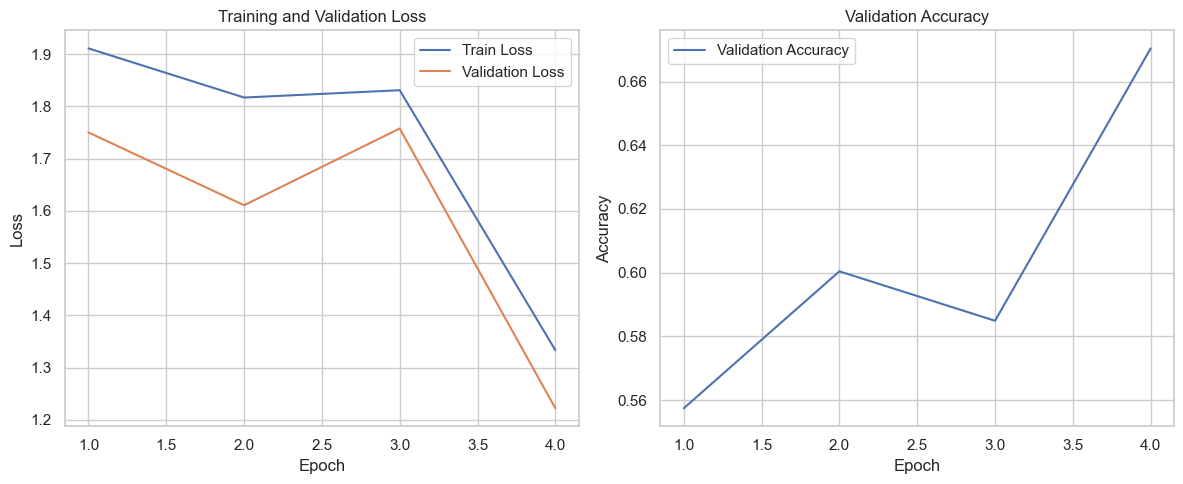

In [20]:
your_model_instance = YourModule(model, backbone_lr=0.05, classifier_lr=0.05)
train_losses, val_losses, val_accuracies = train_model(your_model_instance, train_dataloader, val_dataloader, num_epochs=4)
plot_metrics(train_losses, val_losses, val_accuracies)

In [21]:
for param in model.model.blocks[-1].parameters():
    param.requires_grad = True

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 1/2 - Train Loss: 0.8060 - Test Loss: 0.4401 - Test Accuracy: 0.8932


 50%|█████     | 1/2 [02:24<02:24, 144.78s/it]

Model checkpoint saved at epoch 1 with validation loss: 0.4401
Epoch 2/2 - Train Loss: 0.3924 - Test Loss: 0.2884 - Test Accuracy: 0.9279


100%|██████████| 2/2 [04:56<00:00, 148.23s/it]

Model checkpoint saved at epoch 2 with validation loss: 0.2884


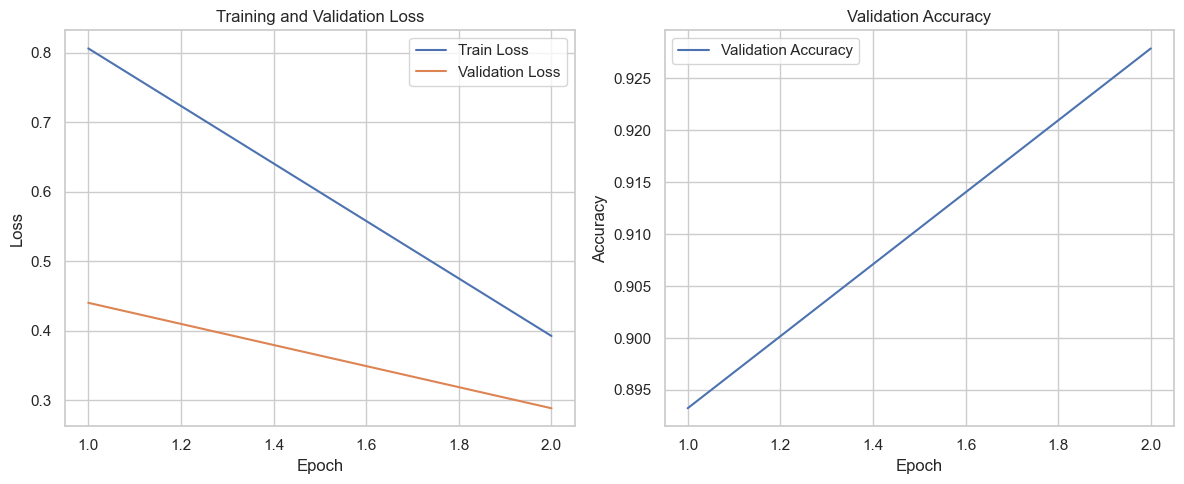

In [22]:
your_model_instance = YourModule(model, backbone_lr=0.03, classifier_lr=0.04)
train_losses, val_losses, val_accuracies = train_model(your_model_instance, train_dataloader, val_dataloader, num_epochs=2)
plot_metrics(train_losses, val_losses, val_accuracies)

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 1/2 - Train Loss: 0.2412 - Test Loss: 0.2310 - Test Accuracy: 0.9429


 50%|█████     | 1/2 [02:19<02:19, 139.25s/it]

Model checkpoint saved at epoch 1 with validation loss: 0.2310


100%|██████████| 2/2 [04:43<00:00, 141.60s/it]

Epoch 2/2 - Train Loss: 0.2080 - Test Loss: 0.2329 - Test Accuracy: 0.9444


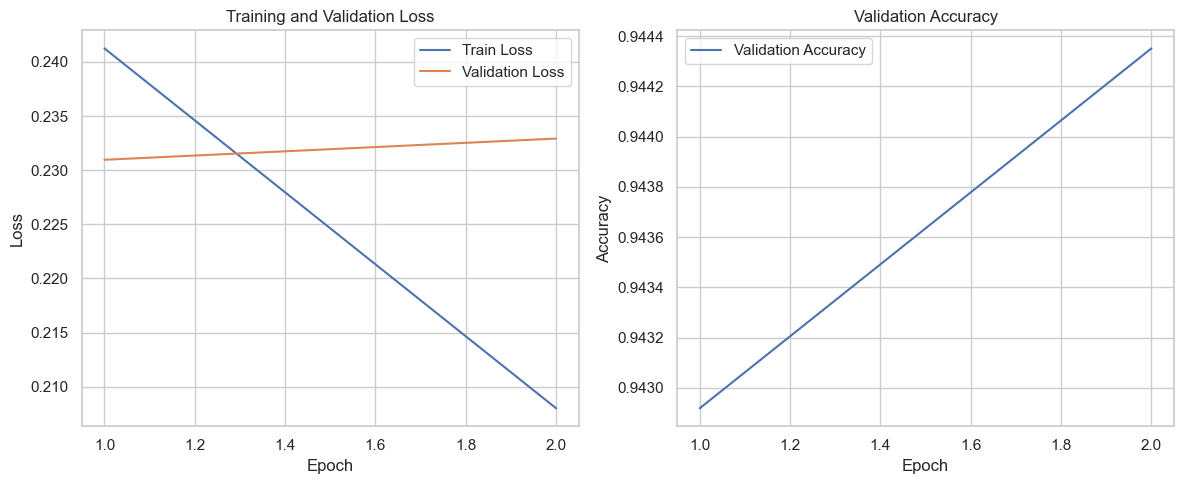

In [23]:
your_model_instance = YourModule(model, backbone_lr=0.02, classifier_lr=0.03)
train_losses, val_losses, val_accuracies = train_model(your_model_instance, train_dataloader, val_dataloader, num_epochs=2)
plot_metrics(train_losses, val_losses, val_accuracies)

In [25]:
for param in model.model.blocks[-2].parameters():
    param.requires_grad = True

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 1/3 - Train Loss: 0.1530 - Test Loss: 0.1763 - Test Accuracy: 0.9601


 33%|███▎      | 1/3 [02:59<05:59, 179.96s/it]

Model checkpoint saved at epoch 1 with validation loss: 0.1763
Epoch 2/3 - Train Loss: 0.0998 - Test Loss: 0.1594 - Test Accuracy: 0.9666


 67%|██████▋   | 2/3 [06:16<03:09, 189.56s/it]

Model checkpoint saved at epoch 2 with validation loss: 0.1594
Epoch 3/3 - Train Loss: 0.0772 - Test Loss: 0.1457 - Test Accuracy: 0.9704


100%|██████████| 3/3 [09:31<00:00, 190.48s/it]

Model checkpoint saved at epoch 3 with validation loss: 0.1457


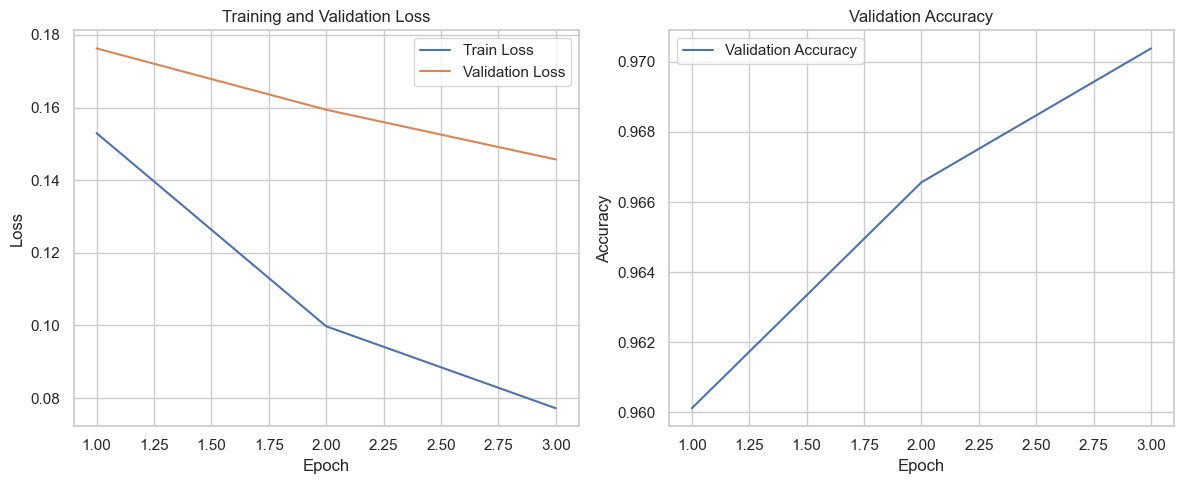

In [26]:
your_model_instance = YourModule(model, backbone_lr=0.015, classifier_lr=0.025)
train_losses, val_losses, val_accuracies = train_model(your_model_instance, train_dataloader, val_dataloader, num_epochs=3)
plot_metrics(train_losses, val_losses, val_accuracies)

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 1/2 - Train Loss: 0.0396 - Test Loss: 0.1304 - Test Accuracy: 0.9759


 50%|█████     | 1/2 [02:54<02:54, 174.22s/it]

Model checkpoint saved at epoch 1 with validation loss: 0.1304
Epoch 2/2 - Train Loss: 0.0328 - Test Loss: 0.1251 - Test Accuracy: 0.9771


100%|██████████| 2/2 [06:08<00:00, 184.33s/it]

Model checkpoint saved at epoch 2 with validation loss: 0.1251


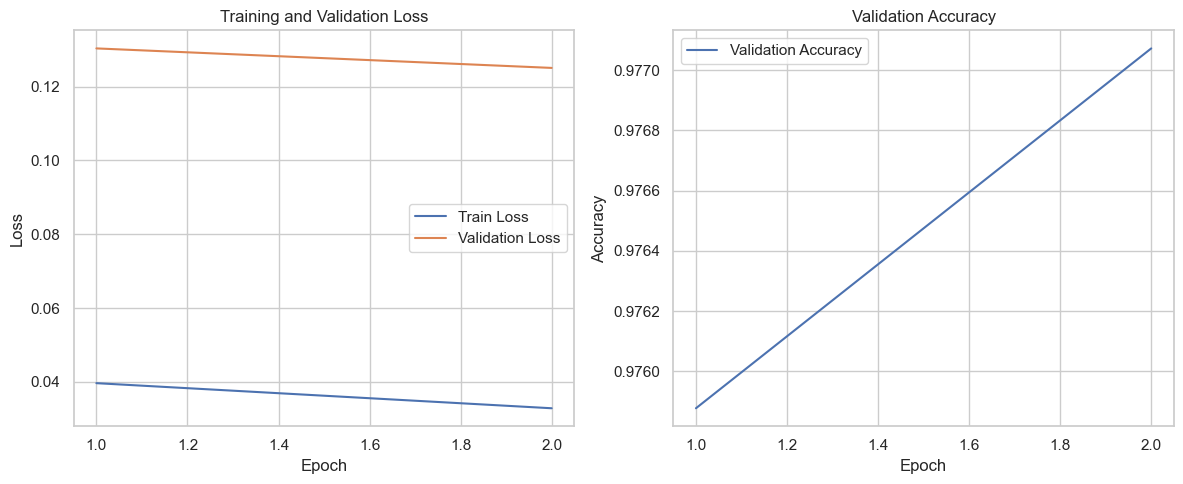

In [28]:
your_model_instance = YourModule(model, backbone_lr=0.005, classifier_lr=0.01)
train_losses, val_losses, val_accuracies = train_model(your_model_instance, train_dataloader, val_dataloader, num_epochs=2)
plot_metrics(train_losses, val_losses, val_accuracies)

## Получение ответов на тестовую выборку

Функция ниже позволит вам получить ответ вашей модели на тестовую выборку. Файл submission_hw05.npy нужно будет отправить на Я.Контест

In [29]:
def get_predictions(model, dataloader):

    predicted_labels = []
    model.eval()
    predicted_labels = []

    for i, batch in enumerate(dataloader):

        # так получаем текущий батч
        X_batch, _ = batch

        with torch.no_grad():
            logits = model(X_batch.to(device))
            y_pred = torch.argmax(logits, dim=1)
            predicted_labels.append(y_pred)

    predicted_labels = torch.cat(predicted_labels)
    return predicted_labels

# model — переменная, в которой находится ваша модель.
predicted_labels = get_predictions(model, test_dataloader)
idx_to_class = {y:x for x, y in class_to_idx.items()}
predicted_labels = [idx_to_class[x] for x in predicted_labels.data.cpu().numpy()]

np.save('submission_hw05.npy', predicted_labels, allow_pickle=True)
print('Ответ сохранен в файл `submission_hw05.npy`')

Ответ сохранен в файл `submission_hw05.npy`
